# Credit Card Fraud Detection with Spark and Python

AML model built on the top of pyspark and trained on the [dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) which contains transactions made by credit cards in September 2013 by european cardholders. \
Made by 
- Ujjwal Kadam (2019UCS2022)
- Ujjwal (2019UCS1633)
- Tarush Bajaj (2019UCS1633) 

In [1]:
# Installing pyspark

!pip3 install pyspark
!pip3 install findspark

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [25]:
# importing modules

import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import explode
from pyspark.sql.functions import split

In [26]:
# initializing the pyspark
spark = SparkSession.builder.appName("Classification with Spark").getOrCreate()

In [29]:
# reading the dataset
data_O = spark.read.load('creditcard.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')
type(data_O)

pyspark.sql.dataframe.DataFrame

In [30]:
# the number of fraud vs number of none-fraud records

classFreq = data_O.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [31]:
# convert the data to pandas type and making the dataset more balanced
import pandas as pd
data= data_O.toPandas()
data= data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.shape

(984, 31)

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


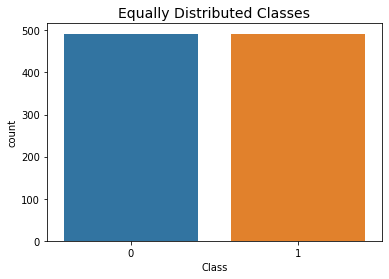

In [32]:
# plot of frauds vs non fraud count

import seaborn as sns
from matplotlib import pyplot as plt
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))
sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

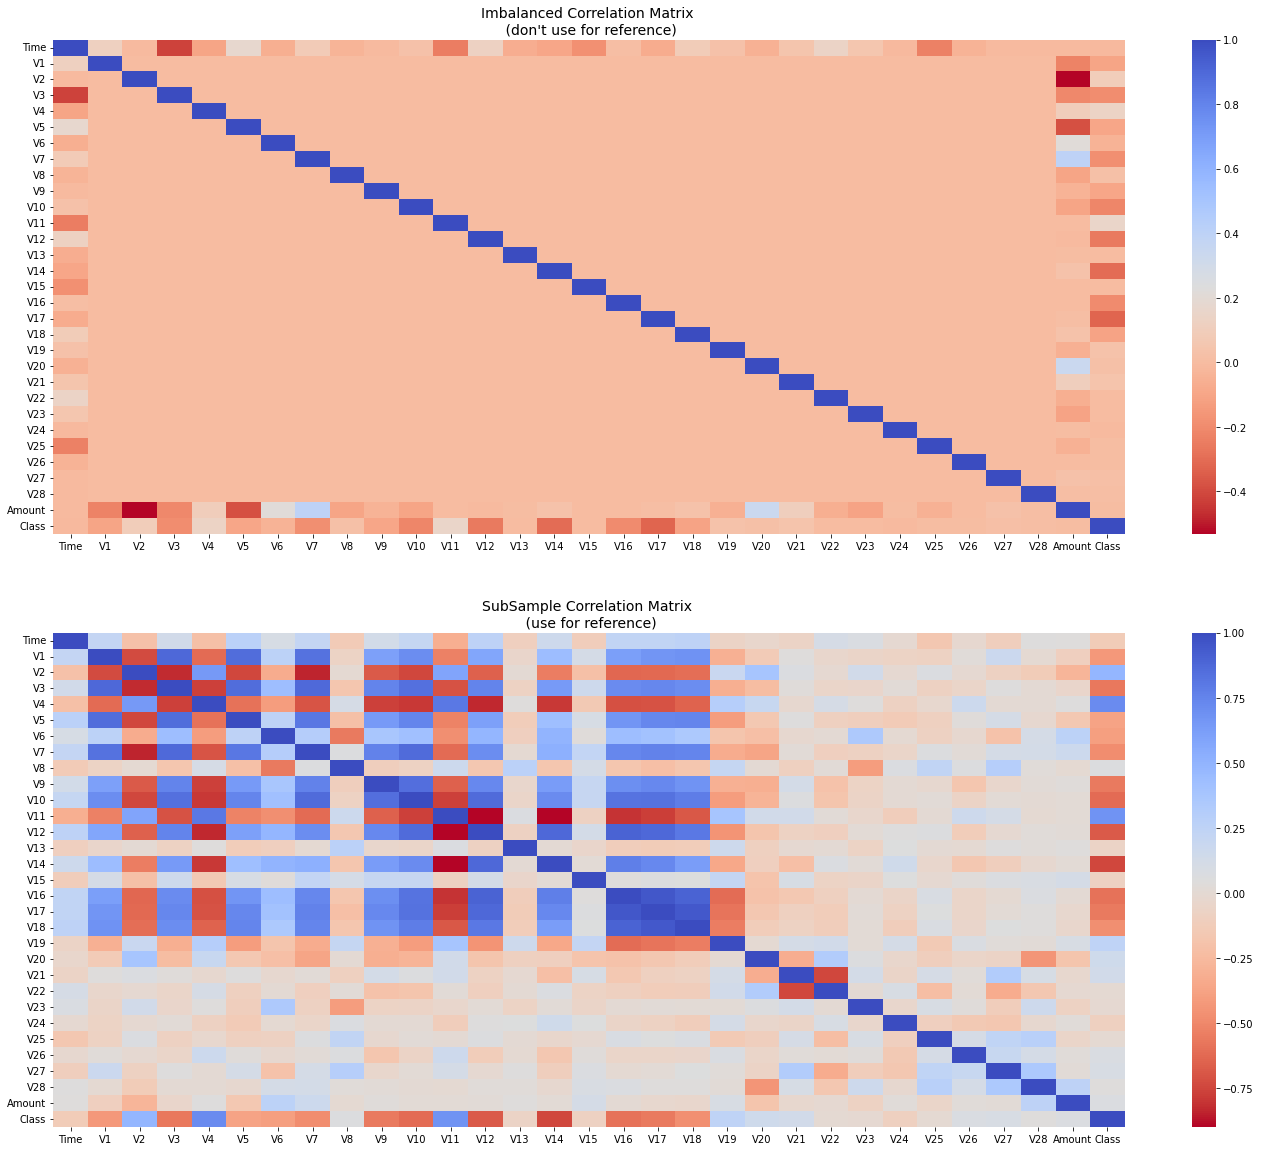

In [33]:
# Make sure we use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))
# Entire DataFrame
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [42]:
# converting back the pandas to spark.sql dataframe and adding index to keep trace of the rows

dfff = spark.createDataFrame(new_df)
from pyspark.sql.functions import *
from pyspark.sql.window import Window
win = Window().orderBy('Time')
dfff = dfff.withColumn("idx", row_number().over(win))

# Machine Learning

In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [44]:
training_df = dfff.rdd.map(lambda x: (DenseVector(x[0:29]),x[30],x[31])) # Dense Vector required in spark to train the data
training_df = spark.createDataFrame(training_df,["features","label","index"])
training_df = training_df.select("index","features","label")
train_data, test_data = training_df.randomSplit([.8,.2],seed=1234)

22/04/21 22:21:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/21 22:21:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/04/21 22:21:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [45]:
# count the training and the testing datasets
train_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  390|
|    1|  362|
+-----+-----+



In [46]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   97|
|    1|   95|
+-----+-----+



In [47]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=8)
model = gbt.fit(train_data)
predictions = model.transform(test_data)
predictions.groupBy("prediction").count().show()

22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB
22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1008.3 KiB
22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1008.9 KiB
22/04/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
22/04/21 22:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1010.2 KiB
22/04/21 22:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
22/04/21 22:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1013.5 KiB
22/04/21 22:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
22/04/21 22:23:03 WAR

22/04/21 22:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1129.5 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1130.0 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1130.8 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1132.1 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1134.1 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1137.6 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1140.7 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1139.6 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1140.2 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1140.6 KiB
22/04/21 22:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1141.5 KiB
22/04/21 22:23:15 WAR

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  100|
|       1.0|   92|
+----------+-----+



22/04/21 22:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1143.0 KiB


In [48]:
# Binary classification evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

22/04/21 22:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1148.7 KiB


0.9590341833966356

In [49]:

predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()

22/04/21 22:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1159.5 KiB


+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   84|
|              0|  108|
+---------------+-----+



22/04/21 22:23:20 WARN DAGScheduler: Broadcasting large task binary with size 1143.2 KiB


In [50]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   97|
|    1|   95|
+-----+-----+



In [51]:
# Calculating accuracy

from pyspark.sql.functions import col
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100
FraudPredictionAccuracy

22/04/21 22:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1166.7 KiB
22/04/21 22:23:38 WARN DAGScheduler: Broadcasting large task binary with size 1144.9 KiB


88.42105263157895

In [52]:
# Calculating the Confusion matrix to have better understanding of the data

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)
print("Recall: ",tp/(tp+fn))
print("Precision: ", tp/(tp+fp))

22/04/21 22:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1154.9 KiB
22/04/21 22:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1154.9 KiB
22/04/21 22:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1154.9 KiB


True Positive:  84 
True Negative:  89 
False Positive:  8 
False Negative:  11
Recall:  0.8842105263157894
Precision:  0.9130434782608695


22/04/21 22:23:51 WARN DAGScheduler: Broadcasting large task binary with size 1154.9 KiB


---